# Week 3 exercise anomaly detection
This assignment will try to find the best configuration for one of the tested algorithms using gridsearch.

In [35]:
import pandas as pd 
import matplotlib.pyplot as plt
import yaml
from sklearn.preprocessing import  MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
import numpy as np

## Loading The data
Loading the data via a config file. 
In the dataframe we can see sensor values and the status of the machine which is either normal, recovering or broken at any point in time. <br>
In sensor 50 allready there are alot off nan values. A good idea is to check if there are sensors with alot of missing values

In [36]:
def get_config():
    with open("../config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

In [37]:
config = get_config()
df = pd.read_csv(config['anomalydetection']).drop('Unnamed: 0', axis = 1)
df

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,NORMAL


In [38]:
df.machine_status.unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

## Clean the data

In [39]:
#missing values
missing = df.isnull().sum()/len(df)*100
missing.sort_values(ascending=False).head()
# sensor 15 has no values so this can be removed from the datafame
# sensor 50 is missing more than 1/3 of the sensor data so this will also be removed from the dataframe

sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
sensor_00      4.633261
sensor_07      2.474129
dtype: float64

In [40]:
# dropping the low quality sensors
df.drop(['sensor_15', 'sensor_50'],inplace=True, axis=1)
# set timestamp to date
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [41]:
df

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,231.1921,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,232.0602,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,234.0856,NORMAL


## Plotting the data
Looking at the data the sensor values have alot of different ranges. for example the first sensor is between 0 and 2.5 but sensor four has most of its values between 700 and 800. for this we are going to normalize the data

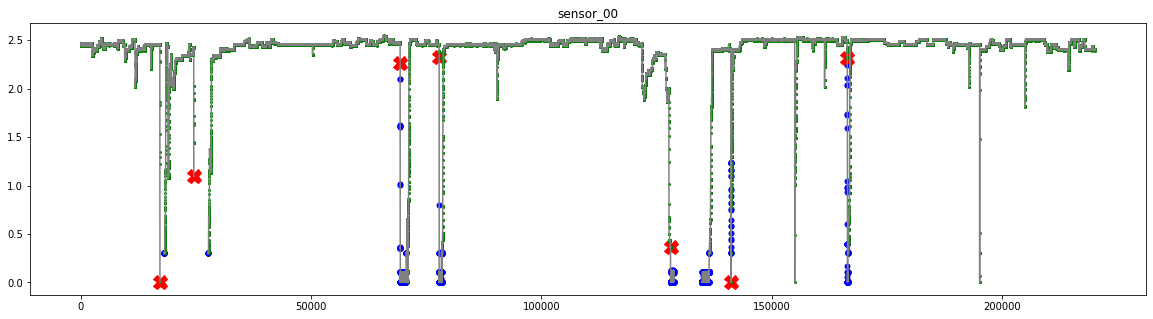

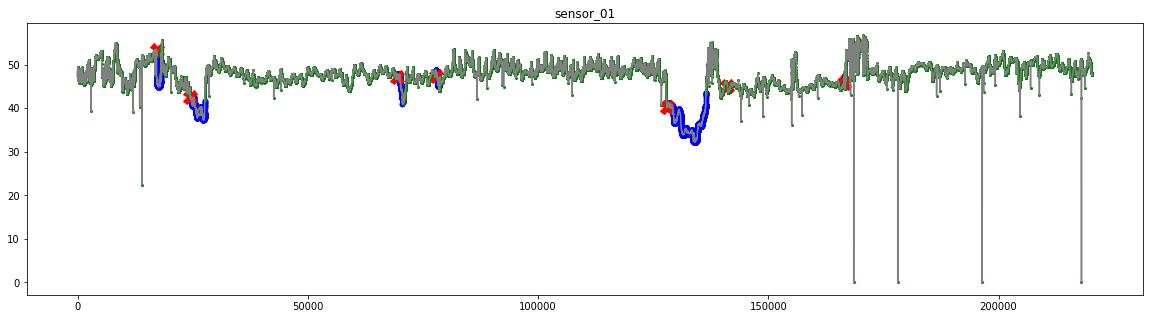

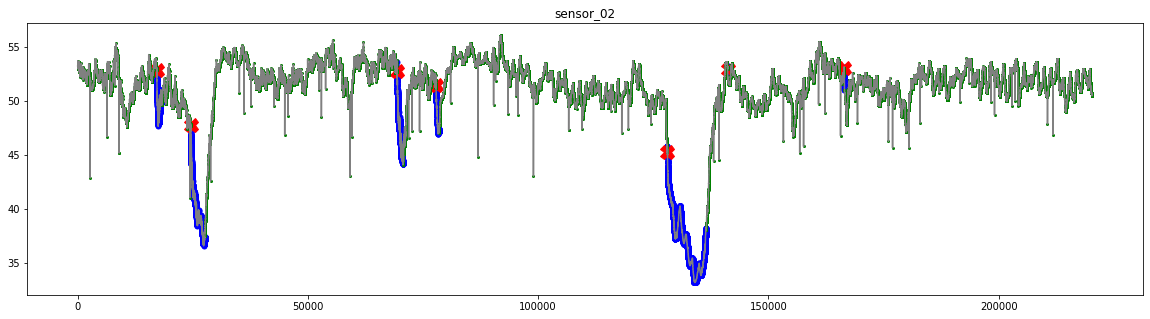

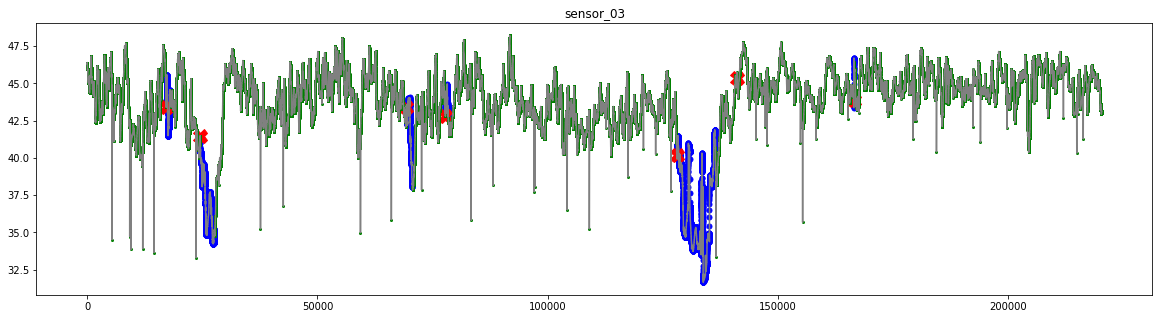

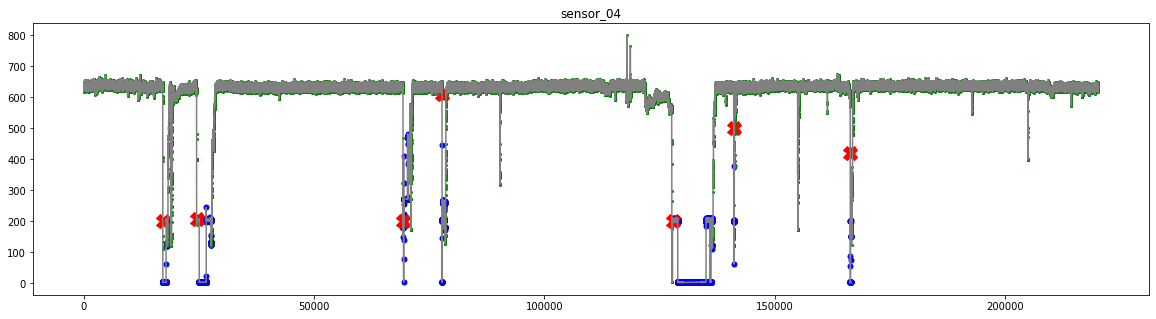

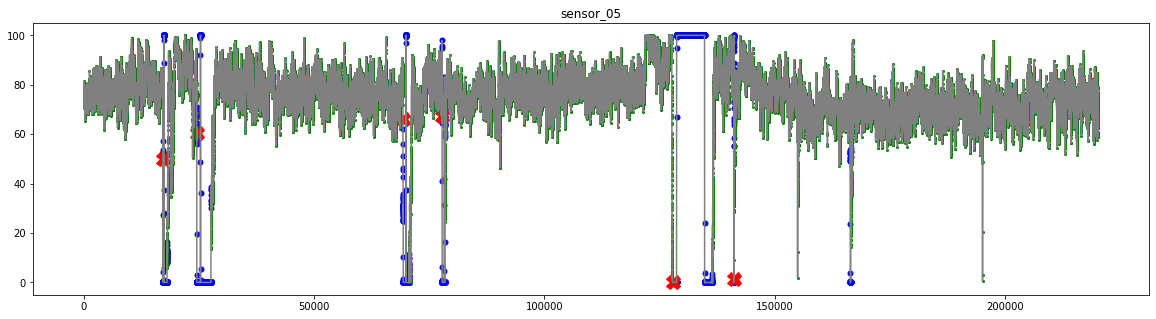

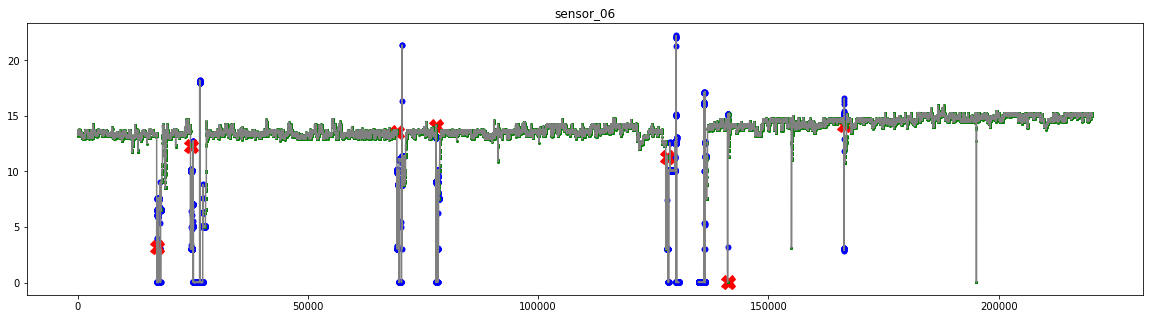

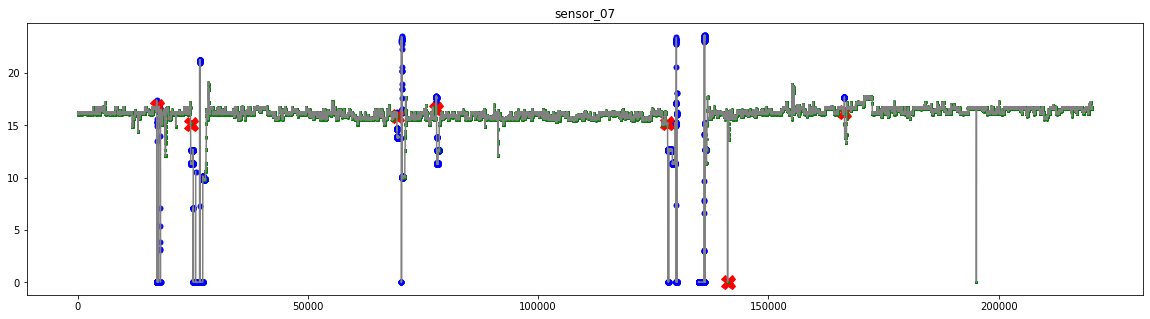

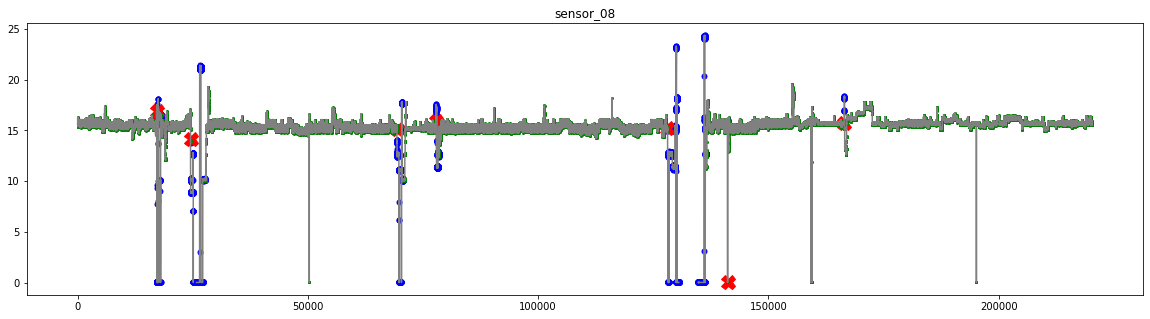

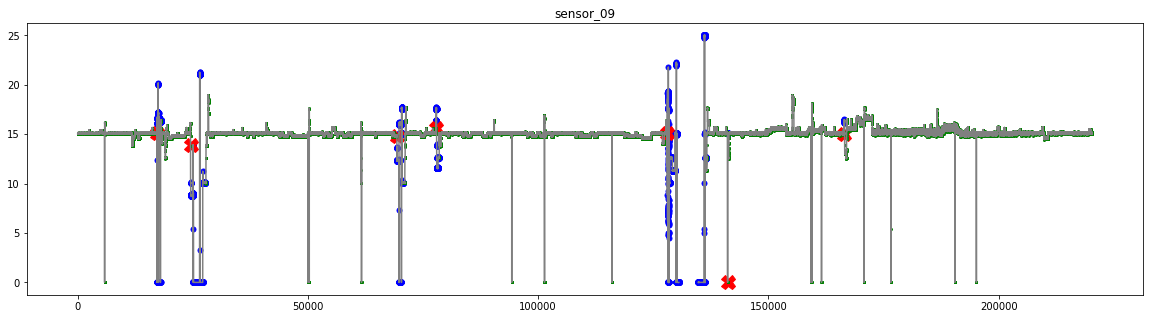

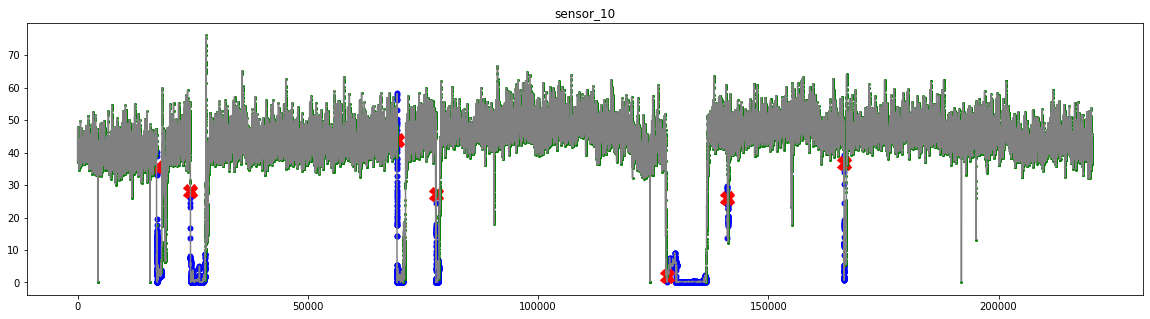

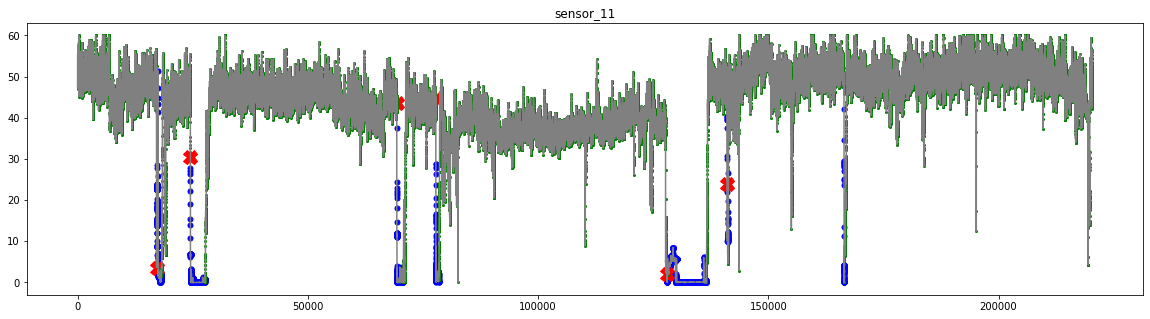

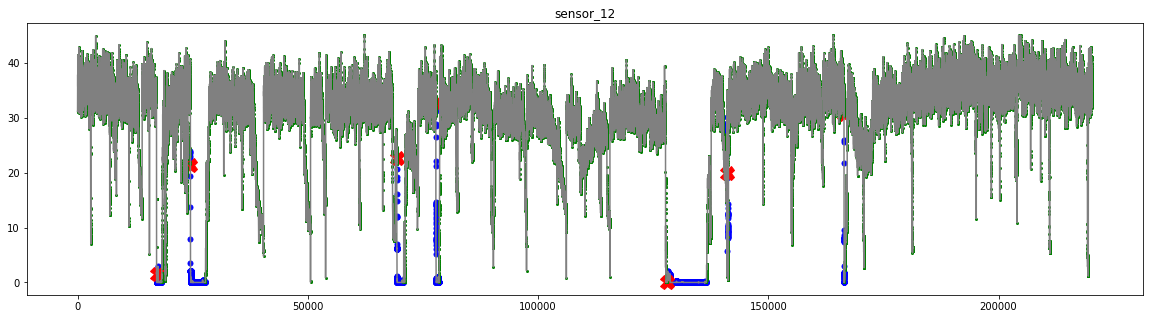

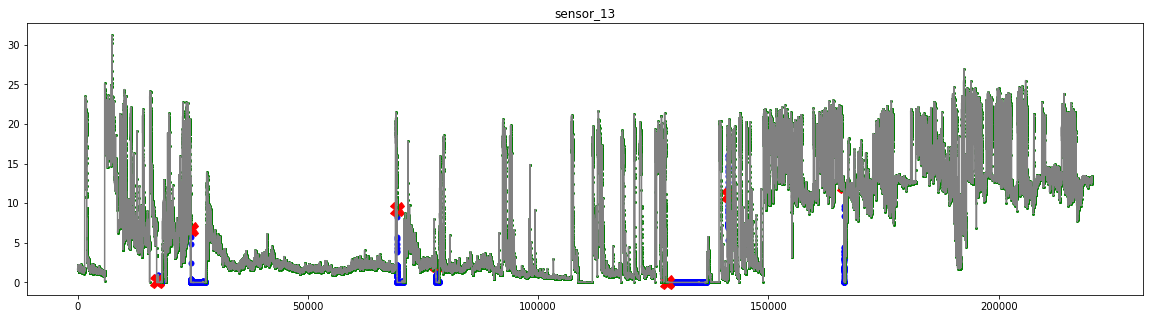

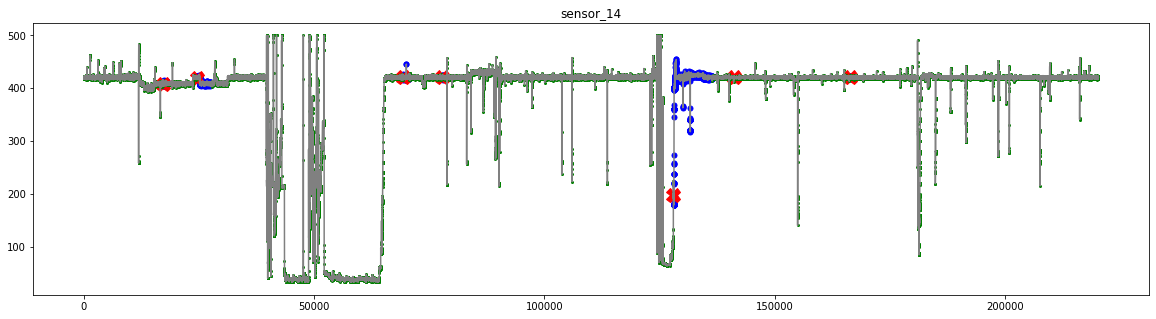

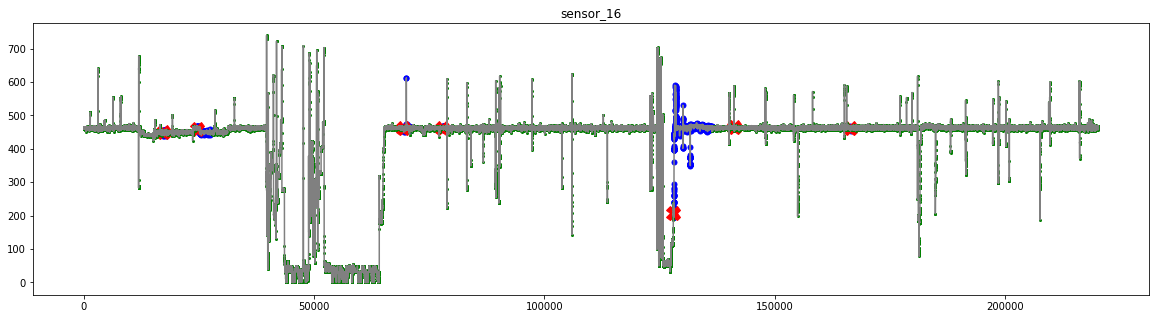

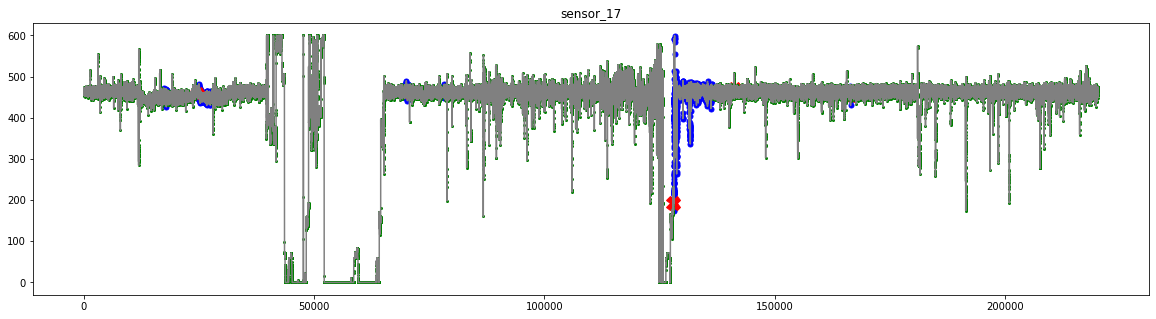

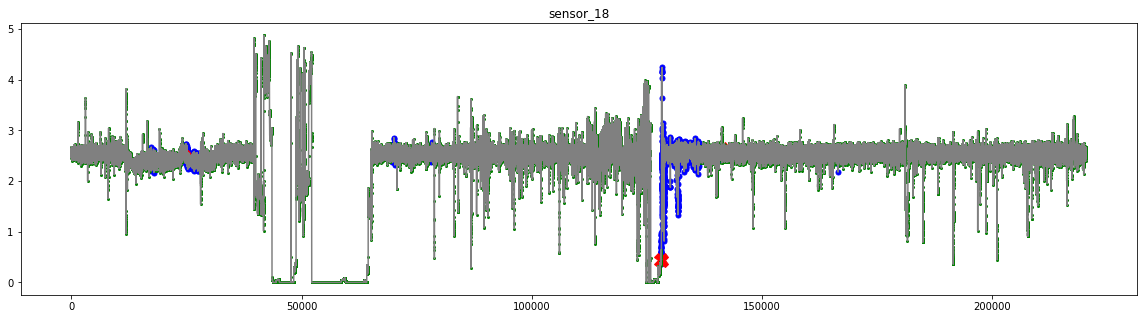

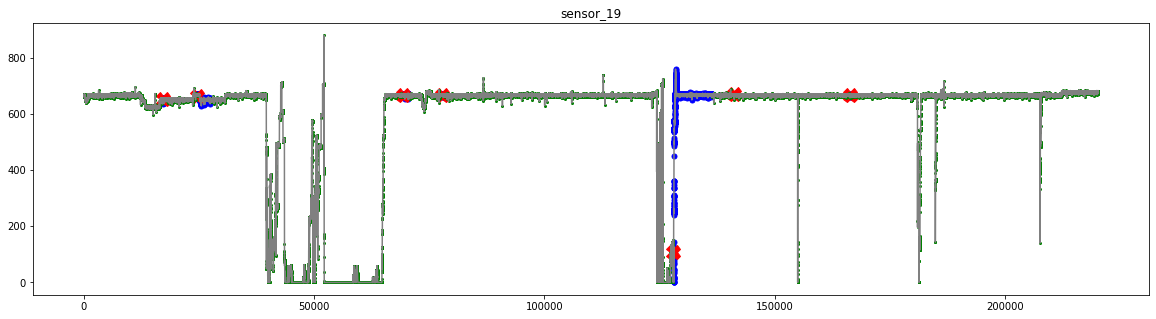

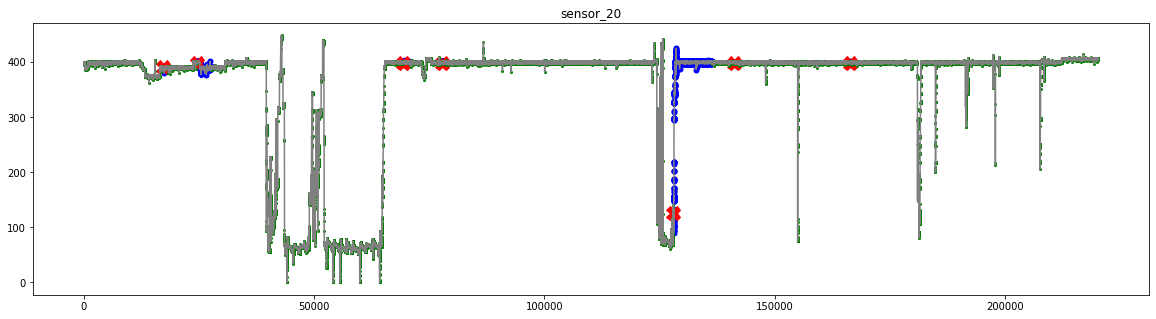

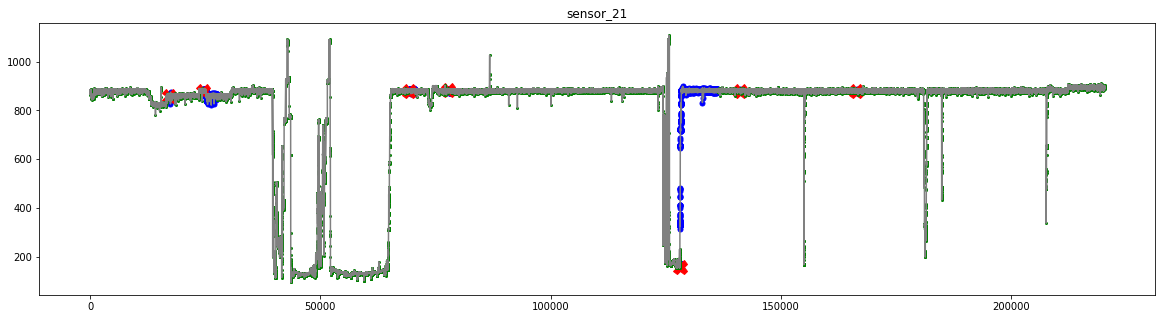

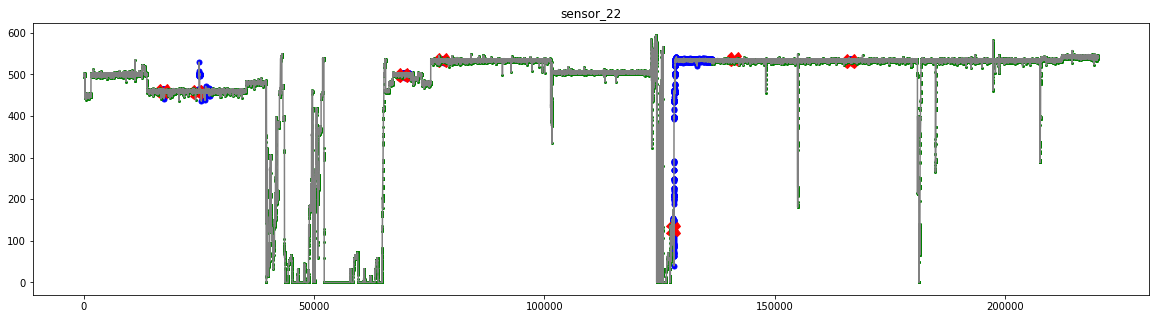

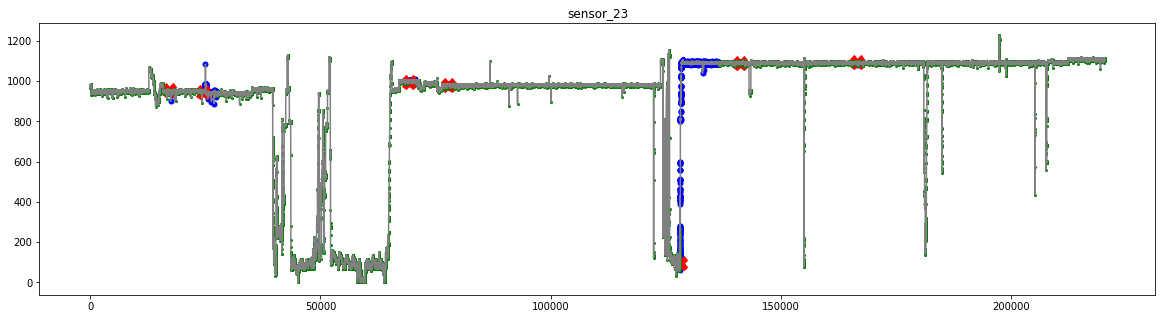

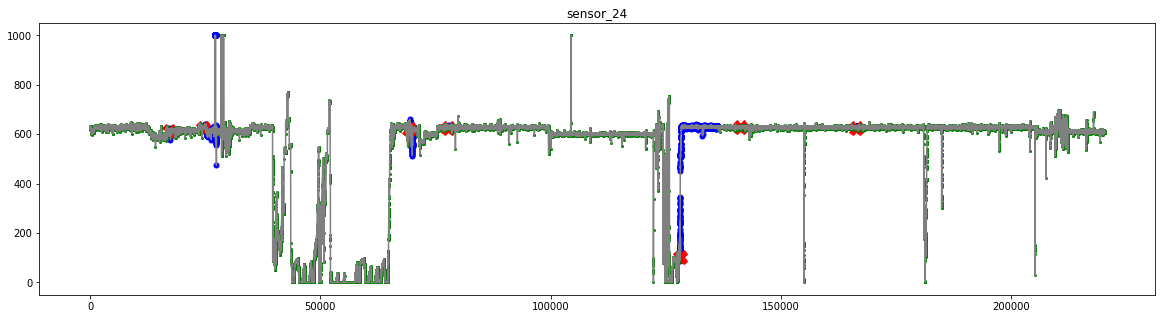

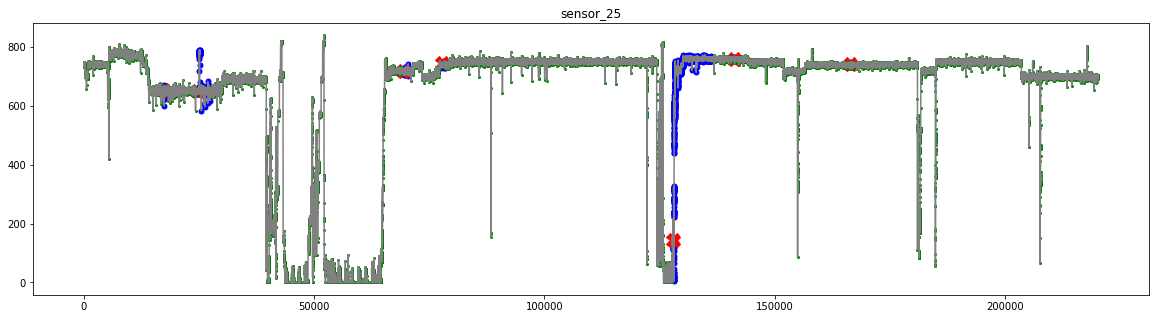

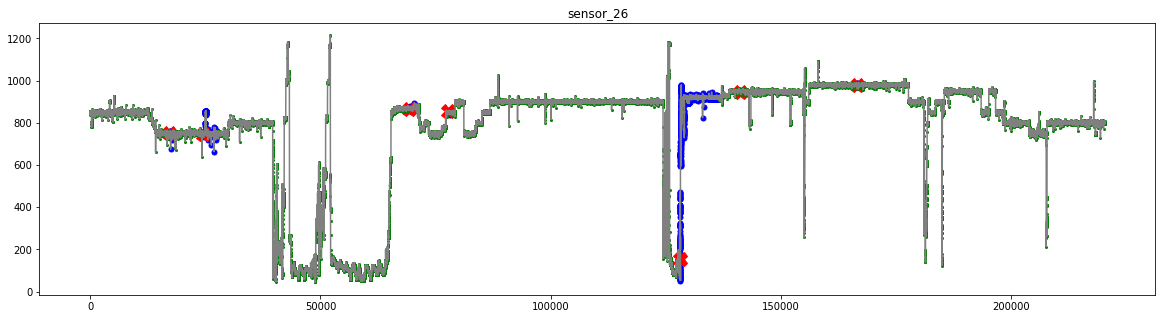

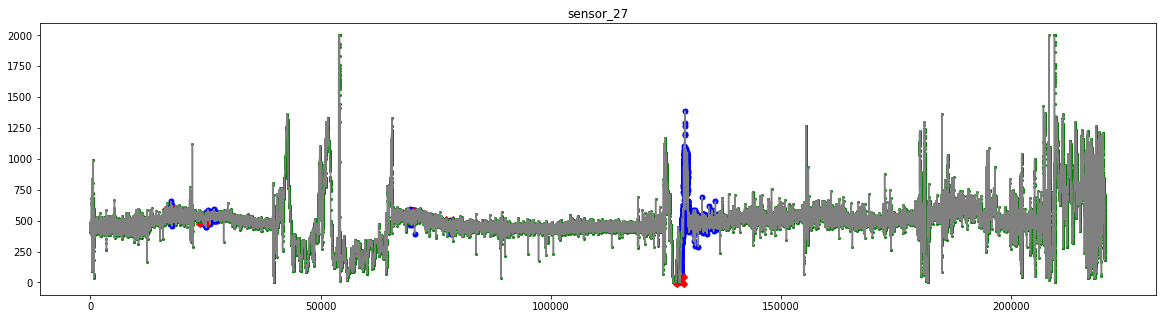

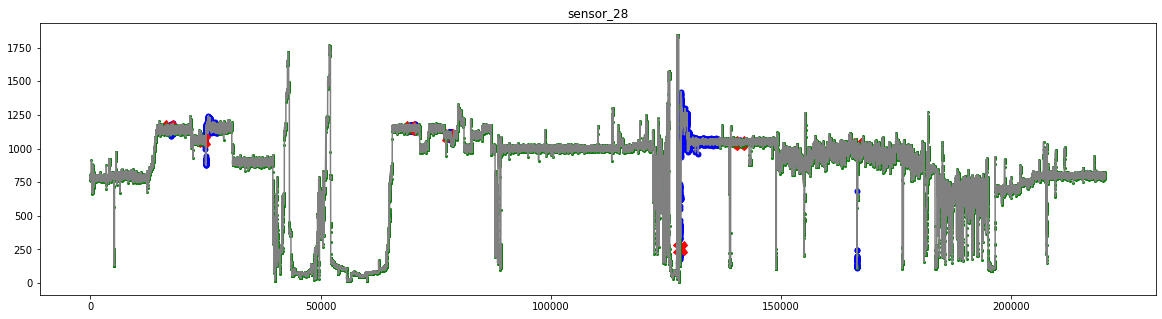

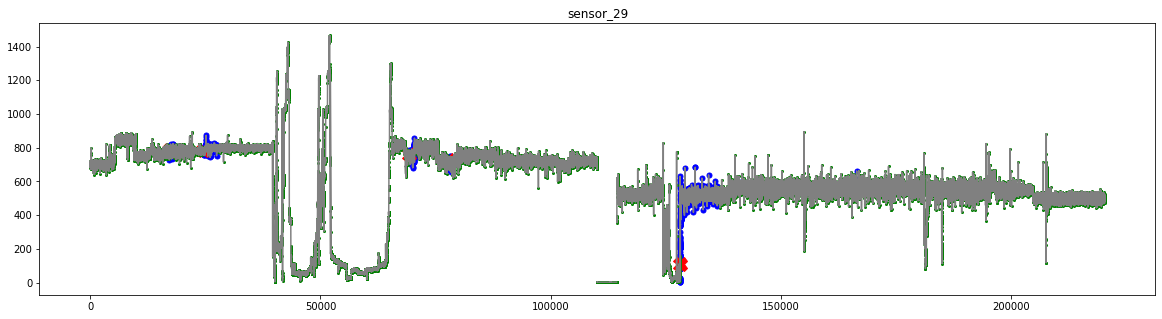

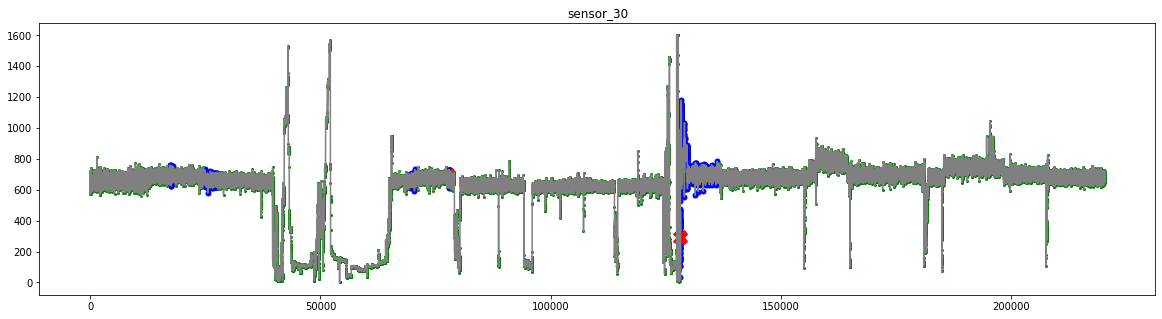

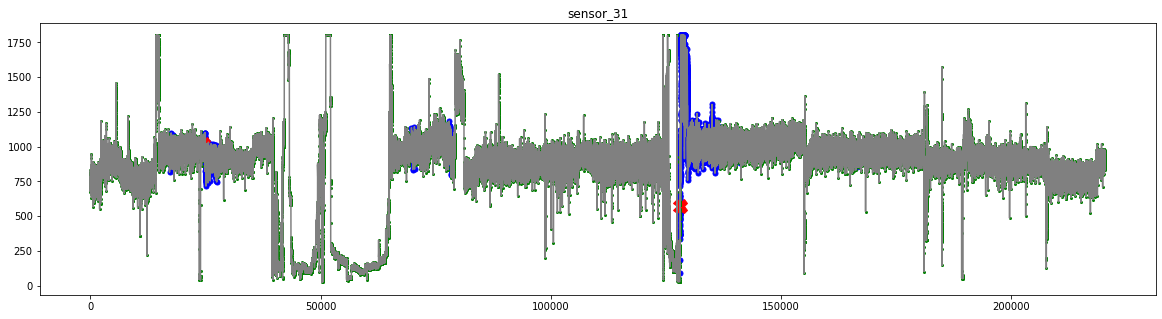

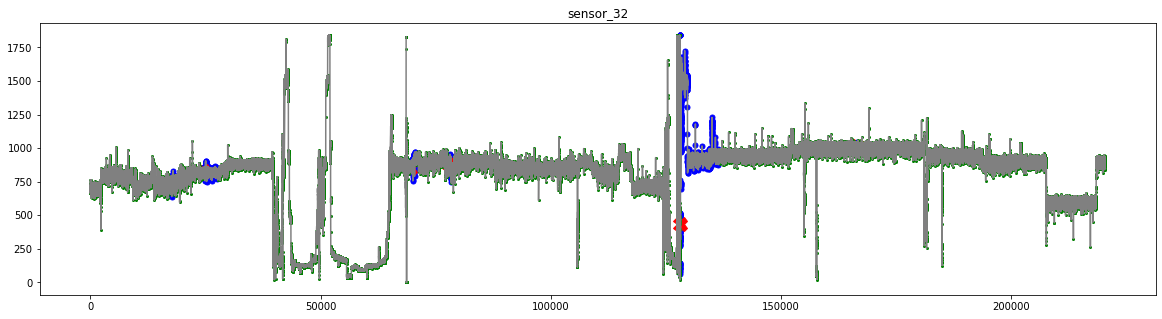

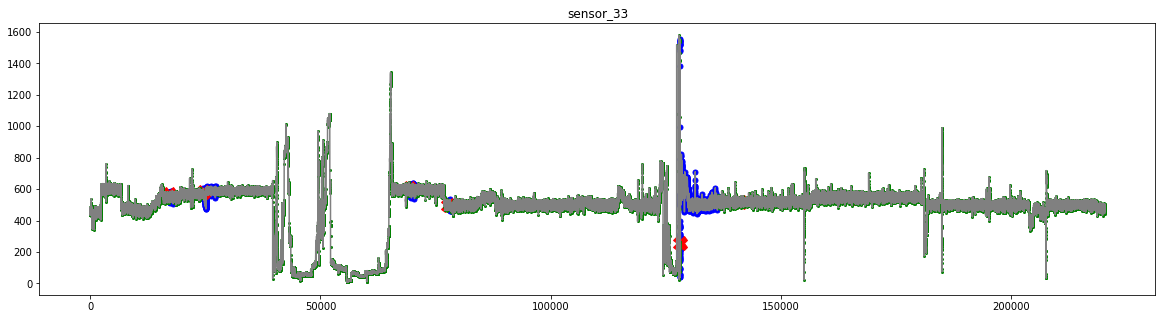

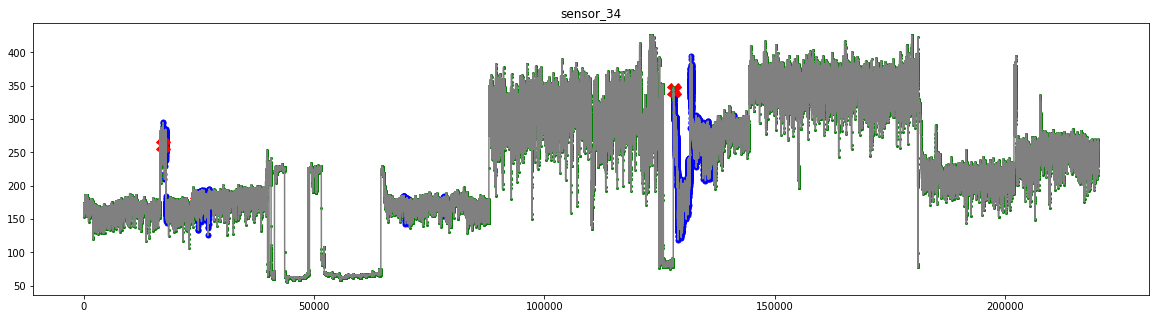

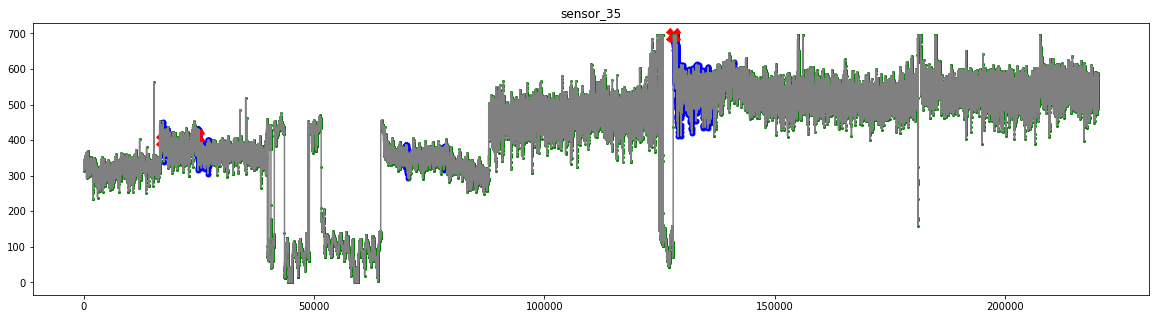

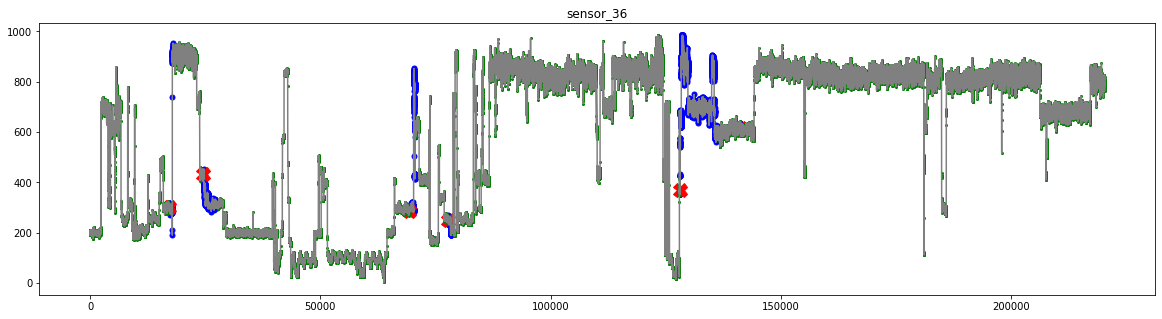

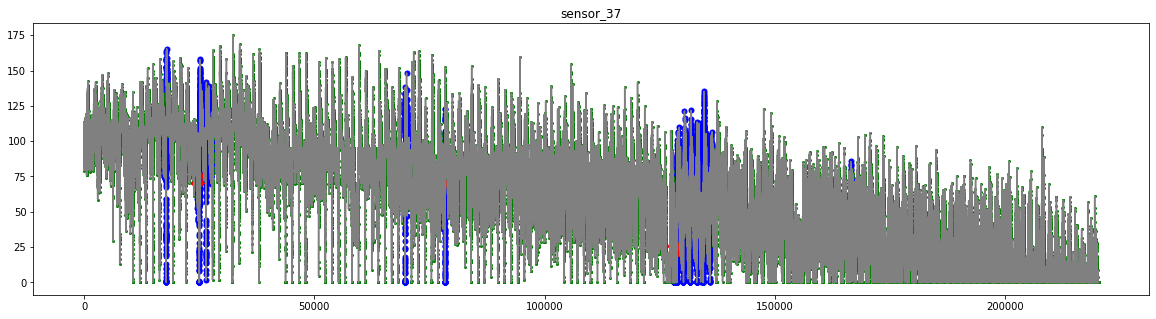

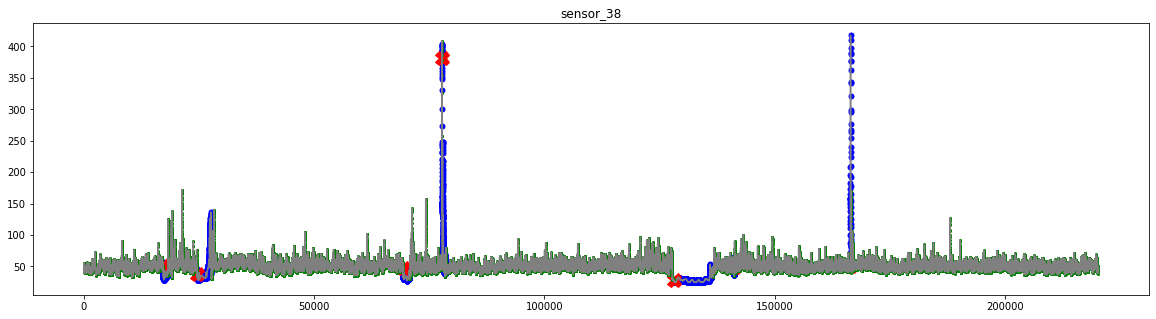

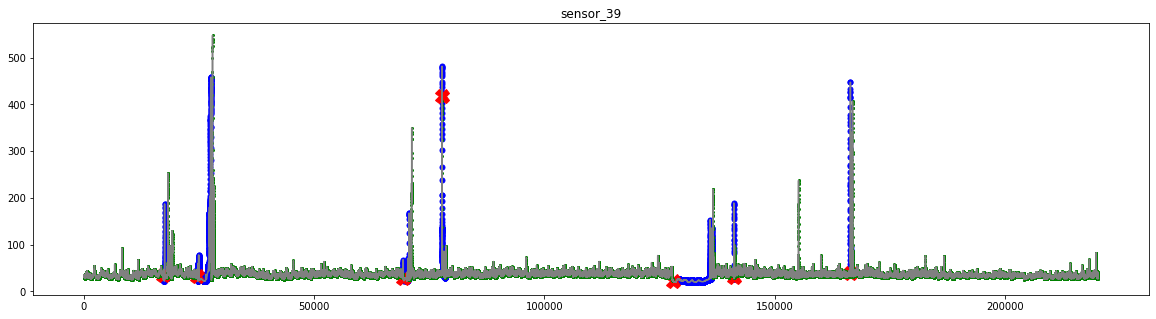

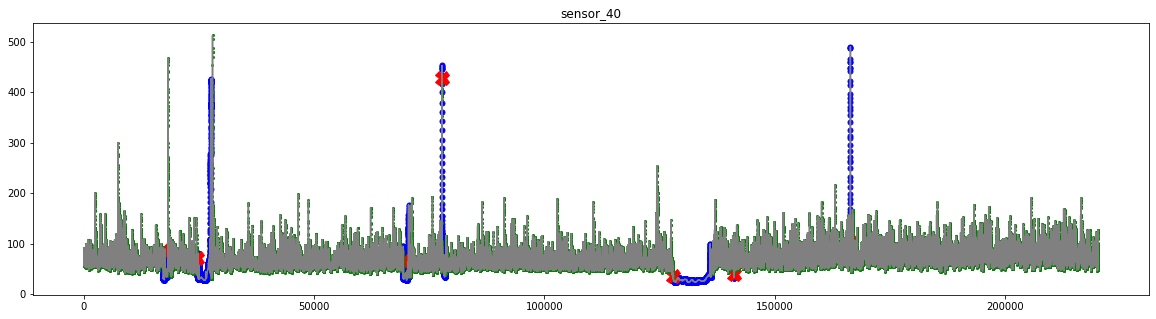

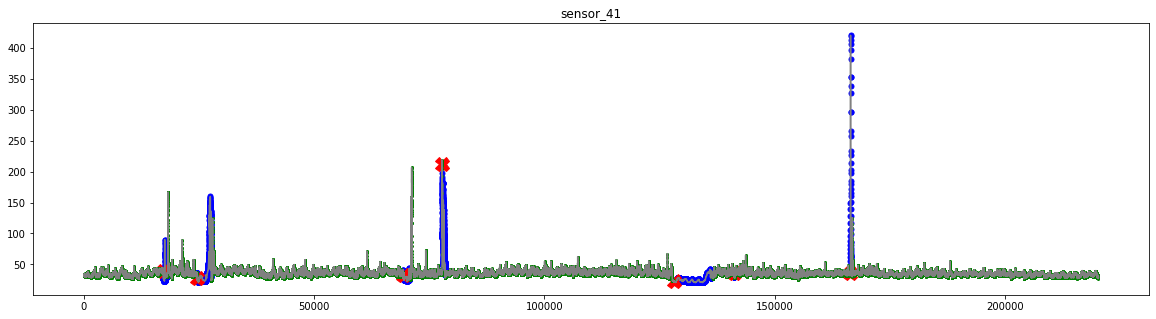

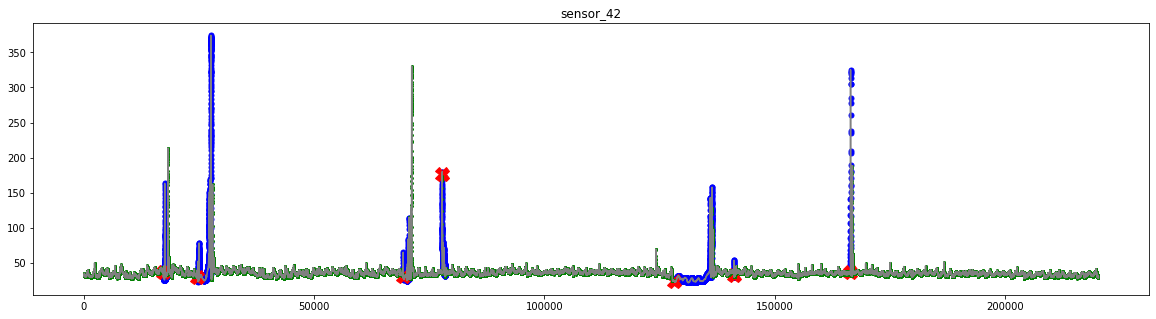

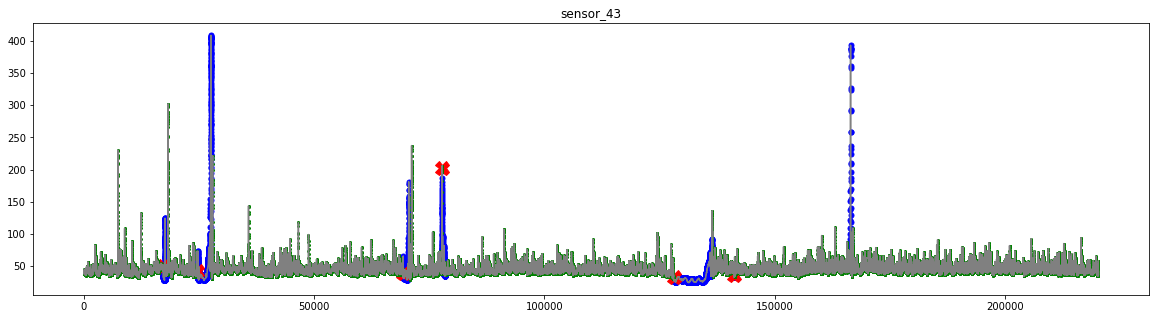

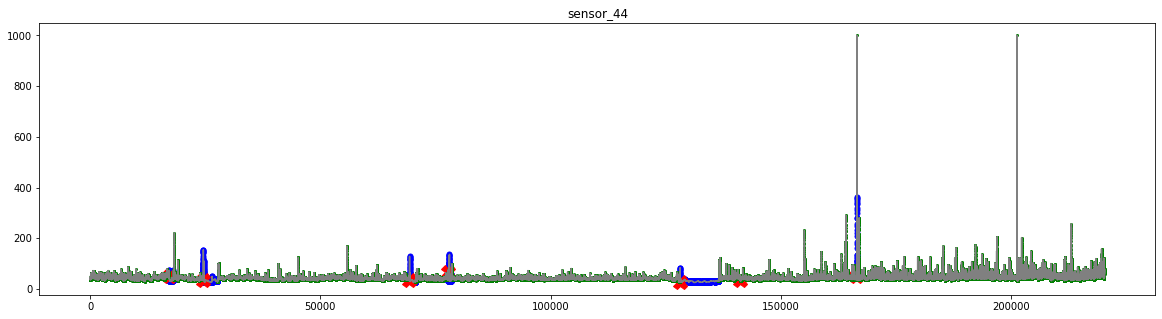

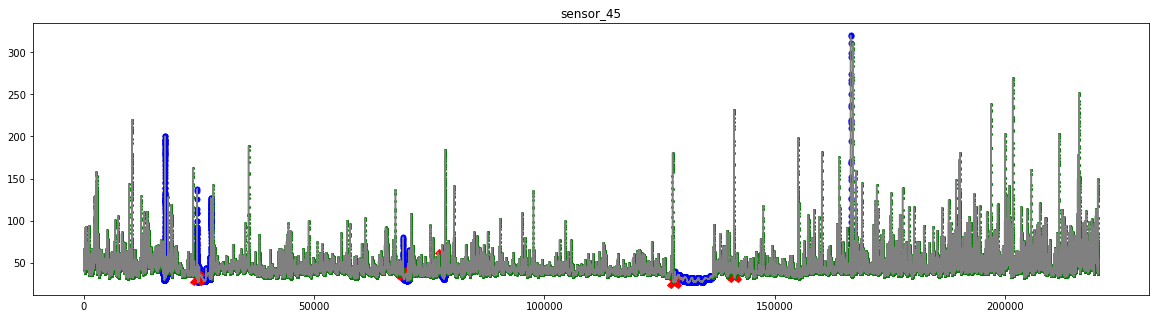

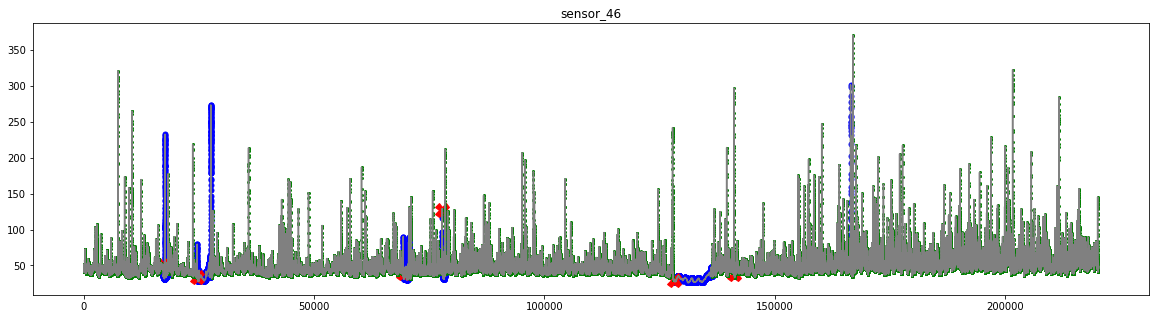

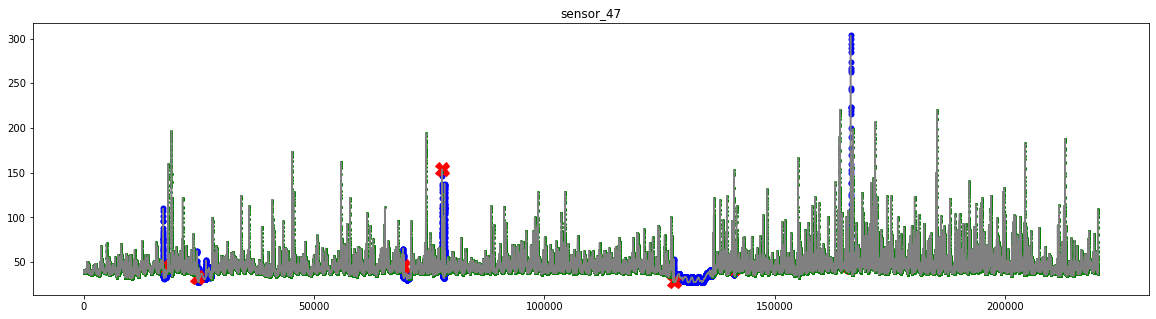

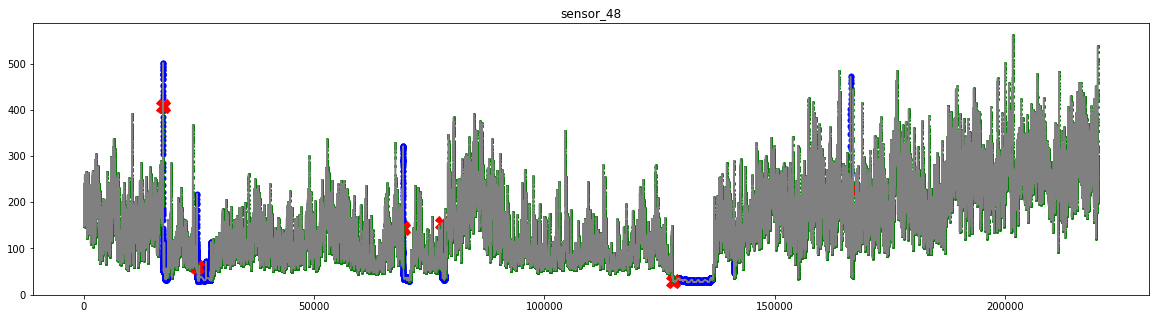

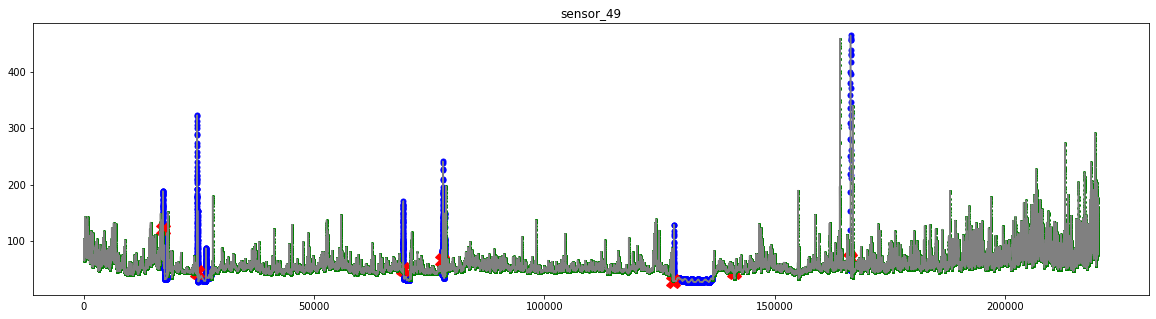

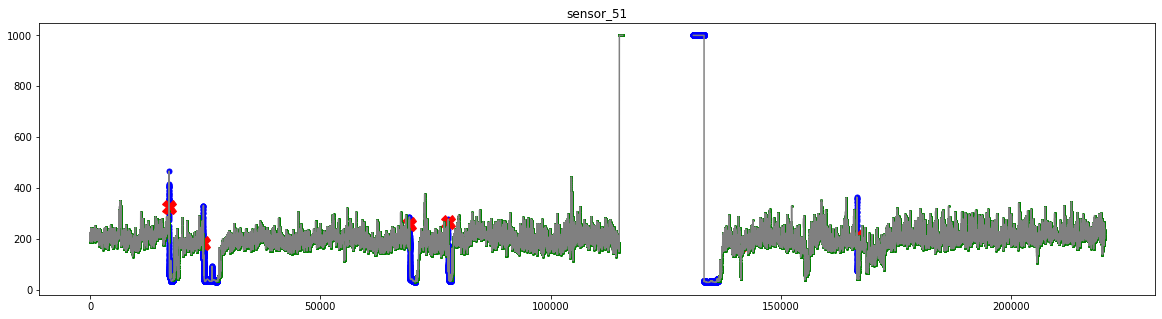

In [42]:
def show_sensor(sensors):
    broken = df[df['machine_status'] == 'BROKEN']
    recovery = df[df['machine_status'] == 'RECOVERING']
    normal = df[df['machine_status'] == 'NORMAL']
    for sensor in sensors:
        plt.figure(figsize=(20,5))
        plt.plot(recovery[sensor], linestyle='none', marker='o', color='blue', markersize=5)
        plt.plot(broken[sensor], linestyle='none', marker='X', color='red', markersize=14)
        plt.plot(normal[sensor], linestyle ='none', marker = 'o', color='green', markersize=2)
        plt.plot(df[sensor], color='grey')
        plt.title(sensor)
        plt.show()

show_sensor(df.iloc[:,1:-1])

# Preprocessing
For the missing values i decided to use ffill so that it replaces it with the value of the previous row. This is because after a peak or drop in value the sensors stopped recording values. a great example of this is sensor 51 where the data is missing after a high peak. Also as previously mentioned i decided to normalize the values using a MinMaxScaler which where all values will be between 0 and 1.

In [43]:
x = df.iloc[:,1:-1].fillna(method = 'ffill')
#scaling

scaler=MinMaxScaler()
X= scaler.fit_transform(x)
print(X)

[[0.9671944  0.83014531 0.87665996 ... 0.2459459  0.09385329 0.17857144]
 [0.9671944  0.83014531 0.87665996 ... 0.2459459  0.09385329 0.17857144]
 [0.95908931 0.83473604 0.87665996 ... 0.24216205 0.0925314  0.18095238]
 ...
 [0.9401777  0.84085688 0.75901303 ... 0.35675664 0.29411756 0.21011906]
 [0.94403723 0.84085688 0.75901312 ... 0.3664865  0.290813   0.21220233]
 [0.9401777  0.84085688 0.75901312 ... 0.37567572 0.28288179 0.21220233]]


## Train the model
Normally with a grid search you would use a score via the class labels of a supervised machine learning algorithm to improve the algorithm.
This method is unsupervised so we need to make our own scoring method and use this to improve the model. 

In [44]:
anomaly_algorithm = IsolationForest(random_state=42)    
parameters = {'n_estimators': np.arange(1,100, 25),
              'contamination': ['auto'],
              'max_samples': ['auto'],
              'bootstrap': [True, False]
     }  



def scorer_f(estimator, X):
      return np.mean(estimator.score_samples(X))

clf = GridSearchCV(anomaly_algorithm, parameters, scoring=scorer_f)
model = clf.fit(X)

In [45]:
model.best_params_

{'bootstrap': True,
 'contamination': 'auto',
 'max_samples': 'auto',
 'n_estimators': 1}